# Medical Blog Generation and Classification Using Clinical Records
# Increment 1: Statistical Approach using TextRank, NER, and TF-IDF
# ==========================================================================

In [ ]:
# Import all required libraries from the first part of the code
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def load_data(file_path, nrows=5000):
    """Load the MIMIC dataset and return a subset of rows"""
    print(f"Loading {nrows} rows from the dataset...")
    df = pd.read_csv(file_path, nrows=nrows)
    print(f"Dataset loaded with shape: {df.shape}")
    return df

def explore_data(df):
    """Perform initial exploration of the dataset"""
    # Display basic information
    print("\n=== Dataset Information ===")
    print(f"Number of records: {len(df)}")
    print(f"Number of columns: {len(df.columns)}")

    # Check for missing values in text columns
    print("\n=== Missing Values in Key Text Columns ===")
    text_columns = ['AdmitDiagnosis', 'AdmitProcedure']
    for col in text_columns:
        if col in df.columns:
            missing = df[col].isna().sum()
            print(f"{col}: {missing} missing values ({missing/len(df)*100:.2f}%)")

    # Display sample admit diagnoses
    if 'AdmitDiagnosis' in df.columns:
        print("\n=== Sample Admit Diagnoses ===")
        non_null_diagnoses = df['AdmitDiagnosis'].dropna()
        for i, diagnosis in enumerate(non_null_diagnoses.sample(5).values):
            print(f"Sample {i+1}: {diagnosis}")

    # Display basic statistics for numerical columns
    print("\n=== Numerical Columns Statistics ===")
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    print(df[numerical_cols].describe().T)

    return None

# Load and explore the data
mimic_df = load_data('/content/mimic3d.csv', nrows=5000)
explore_data(mimic_df)

Loading 5000 rows from the dataset...
Dataset loaded with shape: (5000, 28)

=== Dataset Information ===
Number of records: 5000
Number of columns: 28

=== Missing Values in Key Text Columns ===
AdmitDiagnosis: 1 missing values (0.02%)
AdmitProcedure: 0 missing values (0.00%)

=== Sample Admit Diagnoses ===
Sample 1: HEAD BLEED;URINARY TRACT INFECTION;PNEUMONIA
Sample 2: ACUTE CORONARY SYNDROME
Sample 3: CHOLANGITIS
Sample 4: OPEN WOUND RIGHT FOOT
Sample 5: RECTAL CA/SDA

=== Numerical Columns Statistics ===
                   count           mean          std       min          25%  \
hadm_id           5000.0  104200.536800  2449.375432  100001.0  102068.7500   
age               5000.0      53.262000    25.726238       0.0      43.0000   
LOSdays           5000.0      10.304562    12.900083       0.0       3.6300   
NumCallouts       5000.0       0.100350     0.174411       0.0       0.0000   
NumDiagnosis      5000.0       2.618176     7.726943       0.0       0.8300   
NumProcs    

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def preprocess_text(text, remove_stopwords=True):
    """Preprocess clinical text"""
    if pd.isna(text):
        return ""

    # Convert to lowercase and remove punctuation and numbers
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    text = re.sub(r'\d+', ' ', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        # Create medical stopwords exceptions (words we want to keep)
        medical_exceptions = {'no', 'not', 'none', 'blood', 'heart', 'pain', 'fever'}
        filtered_stop_words = stop_words - medical_exceptions
        tokens = [token for token in tokens if token not in filtered_stop_words]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

def preprocess_dataset(df):
    """Preprocess the dataset"""
    # Create a copy to avoid modifying the original
    processed_df = df.copy()

    # Handle missing values in text columns
    text_columns = ['AdmitDiagnosis', 'AdmitProcedure']
    for col in text_columns:
        if col in processed_df.columns:
            processed_df[col] = processed_df[col].fillna('')

    # Preprocess text columns
    for col in text_columns:
        if col in processed_df.columns:
            print(f"Preprocessing {col}...")
            processed_df[f'preprocessed_{col}'] = processed_df[col].apply(preprocess_text)

    # Create a combined text field for analysis
    processed_df['combined_text'] = ''
    for col in text_columns:
        if col in processed_df.columns:
            processed_df['combined_text'] += processed_df[f'preprocessed_{col}'] + ' '

    # Remove extra spaces
    processed_df['combined_text'] = processed_df['combined_text'].str.strip()

    return processed_df

# Preprocess the dataset
processed_mimic_df = preprocess_dataset(mimic_df)

# Display a sample of preprocessed text
print("\n=== Sample Preprocessed Text ===")
sample_idx = processed_mimic_df.index[0]
print(f"Original AdmitDiagnosis: {mimic_df.loc[sample_idx, 'AdmitDiagnosis']}")
print(f"Preprocessed: {processed_mimic_df.loc[sample_idx, 'preprocessed_AdmitDiagnosis']}")

Preprocessing AdmitDiagnosis...
Preprocessing AdmitProcedure...

=== Sample Preprocessed Text ===
Original AdmitDiagnosis: DIABETIC KETOACIDOSIS
Preprocessed: diabetic ketoacidosis


 Named Entity Recognition (NER)

In [ ]:
def extract_medical_entities(df, text_column='combined_text'):
    """Extract medical entities from text using spaCy's NER"""
    print("Loading spaCy model...")
    nlp = spacy.load("en_core_web_sm")

    # List to store all entities
    all_entities = []
    entity_types = []

    print("Extracting entities...")
    # Process each text and extract entities
    for i, text in enumerate(df[text_column]):
        if i % 500 == 0:
            print(f"Processing record {i}/{len(df)}")

        if pd.isna(text) or text == "":
            all_entities.append([])
            entity_types.append([])
            continue

        # Limit text size to prevent memory issues
        doc = nlp(text[:5000])

        # Extract entities
        entities = [ent.text for ent in doc.ents]
        types = [ent.label_ for ent in doc.ents]

        all_entities.append(entities)
        entity_types.append(types)

    # Add the entities to the dataframe
    df_with_entities = df.copy()
    df_with_entities['extracted_entities'] = all_entities
    df_with_entities['entity_types'] = entity_types

    return df_with_entities

# Extract entities
df_with_entities = extract_medical_entities(processed_mimic_df)

# Display entities for a sample record
print("\n=== Sample Extracted Entities ===")
sample_idx = df_with_entities.index[0]
print(f"Text: {processed_mimic_df.loc[sample_idx, 'combined_text'][:100]}...")
print(f"Entities: {df_with_entities.loc[sample_idx, 'extracted_entities']}")
print(f"Entity Types: {df_with_entities.loc[sample_idx, 'entity_types']}")

Loading spaCy model...
Extracting entities...
Processing record 0/5000
Processing record 500/5000
Processing record 1000/5000
Processing record 1500/5000
Processing record 2000/5000
Processing record 2500/5000
Processing record 3000/5000
Processing record 3500/5000
Processing record 4000/5000
Processing record 4500/5000

=== Sample Extracted Entities ===
Text: diabetic ketoacidosis na...
Entities: []
Entity Types: []


In [ ]:
def textrank_summarize(text, num_sentences=3):
    """Implement TextRank algorithm to extract key sentences from text"""
    if pd.isna(text) or text.strip() == "":
        return ""

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    # If there are fewer sentences than requested, return the original text
    if len(sentences) <= num_sentences:
        return text

    # Create a TF-IDF vectorizer to convert sentences to vectors
    vectorizer = TfidfVectorizer(stop_words='english')

    # Handle case where all sentences might be empty after preprocessing
    try:
        sentence_vectors = vectorizer.fit_transform(sentences)
    except ValueError:
        return " ".join(sentences[:num_sentences])

    # Calculate similarity between all sentence pairs
    similarity_matrix = sentence_vectors * sentence_vectors.T

    # Create a graph from the similarity matrix
    nx_graph = nx.from_scipy_sparse_matrix(similarity_matrix)

    # Apply PageRank algorithm
    scores = nx.pagerank(nx_graph)

    # Rank sentences based on scores
    ranked_sentences = sorted(((scores[i], sentence) for i, sentence in enumerate(sentences)),
                             reverse=True)

    # Select top sentences
    top_sentences = [sentence for _, sentence in ranked_sentences[:num_sentences]]

    # Reorder sentences based on their original order
    ordered_sentences = [sentence for sentence in sentences if sentence in top_sentences]

    # Combine sentences into summary
    summary = ' '.join(ordered_sentences)

    return summary

def generate_summaries(df, text_column='combined_text', num_sentences=3):
    """Generate TextRank summaries for each text in the dataset"""
    print("Generating summaries...")
    df_with_summaries = df.copy()

    # Apply TextRank to each document
    df_with_summaries['textrank_summary'] = df[text_column].apply(
        lambda x: textrank_summarize(x, num_sentences=num_sentences)
    )

    return df_with_summaries

# Generate summaries
df_with_summaries = generate_summaries(df_with_entities)

# Display sample summaries
print("\n=== Sample Summaries ===")
for i, (_, row) in enumerate(df_with_summaries.sample(3).iterrows()):
    print(f"\nSummary {i+1}:")
    print(row['textrank_summary'])

Generating summaries...

=== Sample Summaries ===

Summary 1:
anemia endosc destru lg int les

Summary 2:
supraventricular tachycardia hypotension left heart cardiac cath

Summary 3:
gastrointestinal bleed colonoscopy


In [ ]:
def extract_tfidf_features(df, text_column='combined_text', max_features=1000):
    """Extract TF-IDF features from text"""
    print(f"Extracting TF-IDF features (max_features={max_features})...")

    # Create the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features,
                                      stop_words='english')

    # Fit and transform the text data
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[text_column])

    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()

    return tfidf_matrix, tfidf_vectorizer, feature_names

# Extract TF-IDF features
tfidf_matrix, tfidf_vectorizer, feature_names = extract_tfidf_features(df_with_summaries)

# Display some of the feature names
print("\n=== Sample TF-IDF Features ===")
print(feature_names[:20])

Extracting TF-IDF features (max_features=1000)...
TF-IDF matrix shape: (5000, 1000)

=== Sample TF-IDF Features ===
['aaa' 'abd' 'abdm' 'abdomen' 'abdominal' 'ablation' 'abnormal' 'abscess'
 'access' 'accident' 'account' 'acidosis' 'acute' 'adenoma' 'adhesiolysis'
 'adult' 'afib' 'aflutter' 'agent' 'aicd']


In [ ]:
def prepare_classification_data(df, feature_matrix, target_column='admit_type'):
    """Prepare data for classification"""
    print("Preparing data for classification...")

    # Encode target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df[target_column])

    # Get class names
    class_names = label_encoder.classes_
    print(f"Target classes: {class_names}")

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        feature_matrix, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")

    return X_train, X_test, y_train, y_test, label_encoder

# Prepare classification data
X_train, X_test, y_train, y_test, label_encoder = prepare_classification_data(
    df_with_summaries, tfidf_matrix, target_column='admit_type'
)

Preparing data for classification...
Target classes: ['ELECTIVE' 'EMERGENCY' 'NEWBORN' 'URGENT']
Training set shape: (4000, 1000)
Test set shape: (1000, 1000)


In [ ]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, label_encoder):
    """Train and evaluate Logistic Regression and SVM models"""
    print("Training Logistic Regression model...")
    # Logistic Regression
    lr_model = LogisticRegression(max_iter=1000, C=1.0, random_state=42)
    lr_model.fit(X_train, y_train)

    # Predict and evaluate
    lr_predictions = lr_model.predict(X_test)
    lr_accuracy = accuracy_score(y_test, lr_predictions)
    print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

    # Classification report
    lr_report = classification_report(
        y_test, lr_predictions,
        target_names=label_encoder.classes_,
        output_dict=True
    )

    print("Training SVM model...")
    # SVM (using linear kernel for efficiency)
    svm_model = SVC(kernel='linear', C=1.0, random_state=42)
    svm_model.fit(X_train, y_train)

    # Predict and evaluate
    svm_predictions = svm_model.predict(X_test)
    svm_accuracy = accuracy_score(y_test, svm_predictions)
    print(f"SVM Accuracy: {svm_accuracy:.4f}")

    # Classification report
    svm_report = classification_report(
        y_test, svm_predictions,
        target_names=label_encoder.classes_,
        output_dict=True
    )

    return lr_model, svm_model, lr_report, svm_report

# Train and evaluate models
lr_model, svm_model, lr_report, svm_report = train_and_evaluate_models(
    X_train, X_test, y_train, y_test, label_encoder
)

# Print detailed classification reports
print("\n=== Logistic Regression Classification Report ===")
print(classification_report(y_test, lr_model.predict(X_test), target_names=label_encoder.classes_))

print("\n=== SVM Classification Report ===")
print(classification_report(y_test, svm_model.predict(X_test), target_names=label_encoder.classes_))

Training Logistic Regression model...
Logistic Regression Accuracy: 0.9650
Training SVM model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM Accuracy: 0.9650

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

    ELECTIVE       0.98      0.92      0.95       128
   EMERGENCY       0.96      1.00      0.98       723
     NEWBORN       1.00      1.00      1.00       125
      URGENT       0.00      0.00      0.00        24

    accuracy                           0.96      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.94      0.96      0.95      1000


=== SVM Classification Report ===
              precision    recall  f1-score   support

    ELECTIVE       0.97      0.94      0.95       128
   EMERGENCY       0.96      1.00      0.98       723
     NEWBORN       1.00      1.00      1.00       125
      URGENT       0.00      0.00      0.00        24

    accuracy                           0.96      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.94      0.96      0.95      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

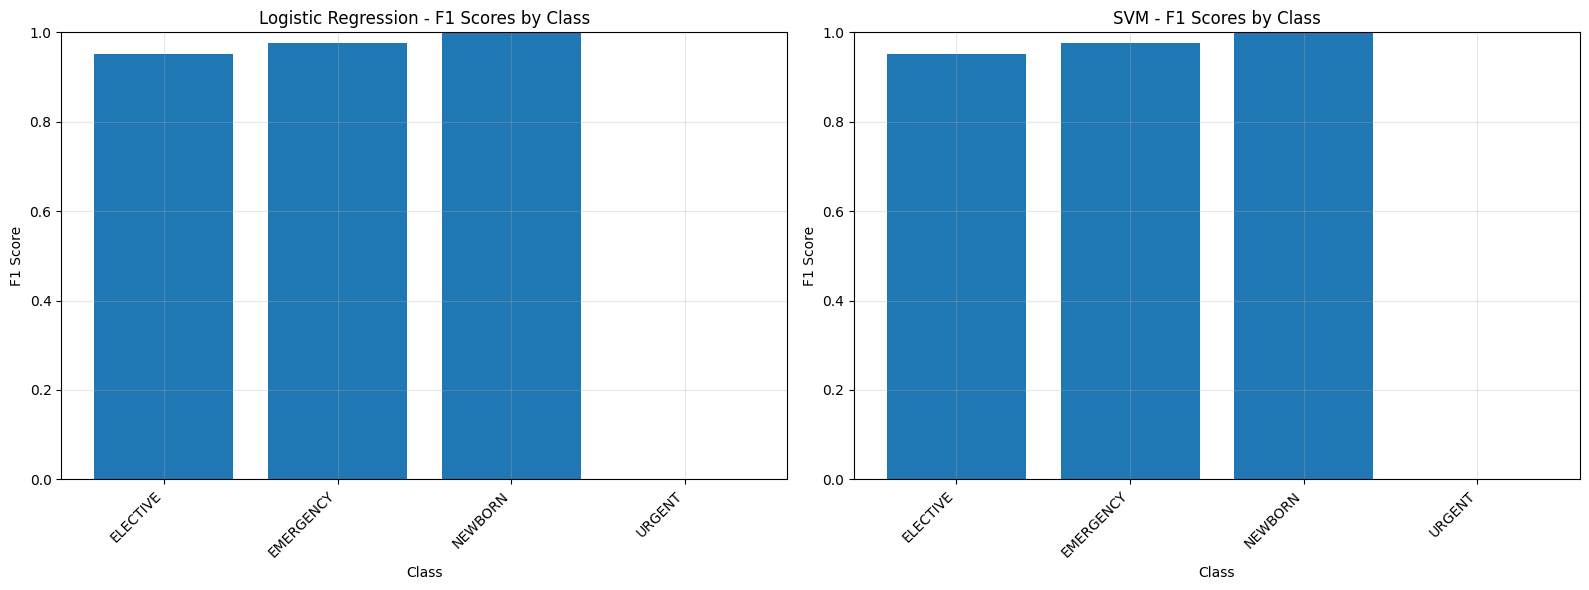

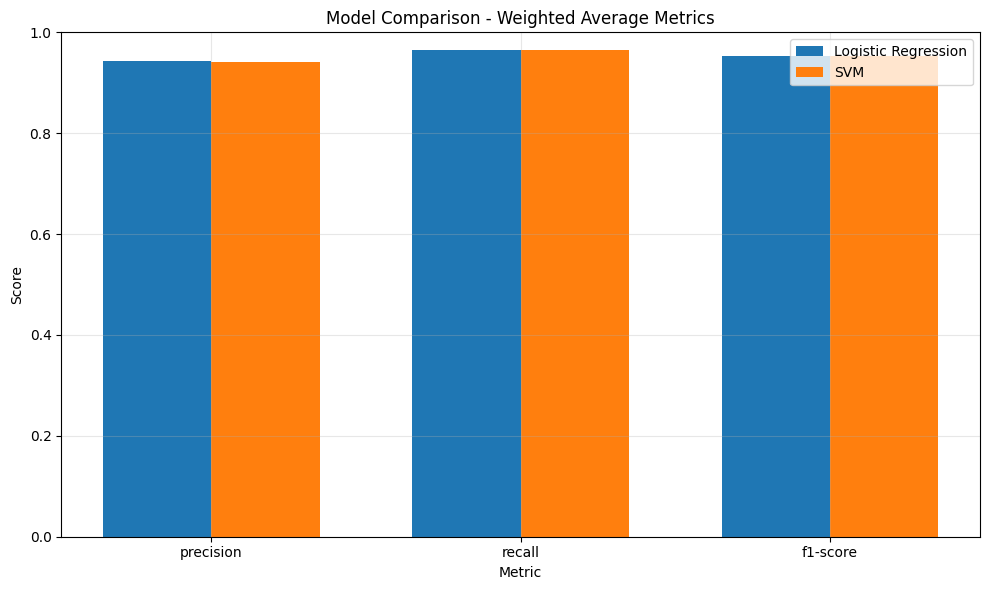

In [ ]:
def visualize_classification_results(lr_report, svm_report, label_encoder):
    """Visualize classification results using bar charts"""
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Extract class-wise F1 scores
    class_names = label_encoder.classes_
    lr_f1_scores = [lr_report[cls]['f1-score'] for cls in class_names]
    svm_f1_scores = [svm_report[cls]['f1-score'] for cls in class_names]

    # Plot F1 scores for Logistic Regression
    ax1.bar(class_names, lr_f1_scores)
    ax1.set_title('Logistic Regression - F1 Scores by Class')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('F1 Score')
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

    # Plot F1 scores for SVM
    ax2.bar(class_names, svm_f1_scores)
    ax2.set_title('SVM - F1 Scores by Class')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('F1 Score')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

    # Compare overall metrics
    metrics = ['precision', 'recall', 'f1-score']
    lr_metrics = [lr_report['weighted avg'][metric] for metric in metrics]
    svm_metrics = [svm_report['weighted avg'][metric] for metric in metrics]

    plt.figure(figsize=(10, 6))
    width = 0.35
    x = np.arange(len(metrics))

    plt.bar(x - width/2, lr_metrics, width, label='Logistic Regression')
    plt.bar(x + width/2, svm_metrics, width, label='SVM')

    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title('Model Comparison - Weighted Average Metrics')
    plt.xticks(x, metrics)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Visualize classification results
visualize_classification_results(lr_report, svm_report, label_encoder)

Generate Final Medical Blogs

In [ ]:
def generate_medical_blogs(df, summaries, predictions, label_encoder, n_samples=5):
    """Generate final medical blogs using summaries and predictions"""
    # Convert numeric predictions to class names
    predicted_classes = label_encoder.inverse_transform(predictions)

    # Create a DataFrame with blogs
    blogs_df = pd.DataFrame({
        'original_text': df['combined_text'],
        'blog_content': summaries,
        'medical_category': predicted_classes
    })

    # Display sample blogs
    print(f"\n=== Sample Medical Blogs ({n_samples}) ===")
    samples = blogs_df.sample(n_samples)

    for i, (_, row) in enumerate(samples.iterrows()):
        print(f"\nBlog {i+1} - Category: {row['medical_category']}")
        print("=" * 50)
        print(row['blog_content'])
        print("=" * 50)

    return blogs_df

# Generate predictions for the entire dataset with the better model
if svm_report['weighted avg']['f1-score'] > lr_report['weighted avg']['f1-score']:
    print("Using SVM model for final predictions...")
    full_predictions = svm_model.predict(tfidf_matrix)
    best_model = svm_model
else:
    print("Using Logistic Regression model for final predictions...")
    full_predictions = lr_model.predict(tfidf_matrix)
    best_model = lr_model

# Generate blogs
blogs_df = generate_medical_blogs(
    df_with_summaries, df_with_summaries['textrank_summary'],
    full_predictions, label_encoder
)

# Save the blogs
blogs_df.to_csv('/content/generated_medical_blogs.csv', index=False)
print("Results saved to '/content/generated_medical_blogs.csv'")

Using SVM model for final predictions...

=== Sample Medical Blogs (5) ===

Blog 1 - Category: EMERGENCY
seizure craniectomy

Blog 2 - Category: EMERGENCY
congestive heart failure non st elevation mi respiratory distress na

Blog 3 - Category: EMERGENCY
foreign body stomach sm bowel endoscopy nec

Blog 4 - Category: EMERGENCY
systolic dysfunction cath heart vessel op nec

Blog 5 - Category: EMERGENCY
aortic stenosis opn oth rep aortic valve
Results saved to '/content/generated_medical_blogs.csv'



=== Blog Quality Metrics ===
Average blog length (characters): 39.60
Average sentences per blog: 1.00
Average words per blog: 5.94
Average words per sentence: 5.94


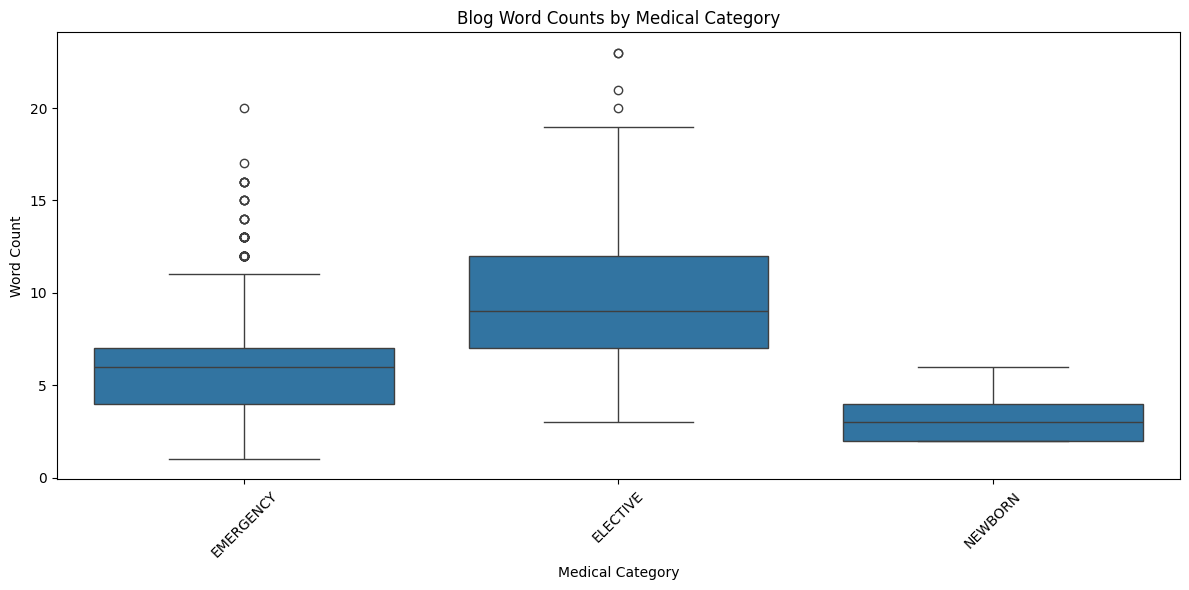

In [ ]:
def evaluate_blog_quality(blogs_df):
    """Analyze the quality of generated blogs"""
    # Calculate blog length statistics
    blogs_df['blog_length'] = blogs_df['blog_content'].apply(len)
    blogs_df['blog_sentence_count'] = blogs_df['blog_content'].apply(
        lambda x: len(sent_tokenize(x)) if pd.notna(x) else 0
    )

    # Calculate word count
    blogs_df['word_count'] = blogs_df['blog_content'].apply(
        lambda x: len(word_tokenize(x)) if pd.notna(x) else 0
    )

    # Calculate words per sentence (simple readability metric)
    blogs_df['words_per_sentence'] = blogs_df.apply(
        lambda row: row['word_count'] / row['blog_sentence_count'] if row['blog_sentence_count'] > 0 else 0,
        axis=1
    )

    # Print summary statistics
    print("\n=== Blog Quality Metrics ===")
    print(f"Average blog length (characters): {blogs_df['blog_length'].mean():.2f}")
    print(f"Average sentences per blog: {blogs_df['blog_sentence_count'].mean():.2f}")
    print(f"Average words per blog: {blogs_df['word_count'].mean():.2f}")
    print(f"Average words per sentence: {blogs_df['words_per_sentence'].mean():.2f}")

    # Distribution of blog lengths by category
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='medical_category', y='word_count', data=blogs_df)
    plt.title('Blog Word Counts by Medical Category')
    plt.xlabel('Medical Category')
    plt.ylabel('Word Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return blogs_df

# Evaluate blog quality
blogs_df_with_metrics = evaluate_blog_quality(blogs_df)